In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.optimizers import Adam
import tensorflow as tf
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

tf.random.set_seed(13)

# Load data
df = pd.read_csv('/content/SingleTweets.csv')

# Missing values
cols_with_nan = df.columns[df.isna().any()].tolist()
for col in cols_with_nan:
    if df[col].isna().any():
        df[col] = df.groupby('Class')[col].transform(lambda x: x.fillna(x.mode().iloc[0]))

# Split data
predictors = df.drop(["Tweet", "Class"], axis=1)
target = df["Class"]

# threshold level
threshold = 0.35

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Initialize lists
all_train_loss = []
all_val_loss = []

for train_index, test_index in skf.split(predictors, target):
    X_train, X_test = predictors.iloc[train_index], predictors.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

    # Standardize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Train the autoencoder
    autoencoder_epochs = 50
    autoencoder_batch_size = 32

    input_dim = X_train_scaled.shape[1]
    latent_dim = 16

    # Architecture
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(256, activation="relu")(input_layer)
    encoded = Dense(128, activation="relu")(encoded)
    encoded = Dense(64, activation="relu")(encoded)
    encoded = Dense(32, activation="relu")(encoded)
    encoded = Dense(16, activation="relu")(encoded)
    decoded = Dense(16, activation="relu")(encoded)
    decoded = Dense(32, activation="relu")(decoded)
    decoded = Dense(64, activation="relu")(decoded)
    decoded = Dense(128, activation="relu")(decoded)
    decoded = Dense(256, activation="relu")(decoded)
    decoded = Dense(input_dim, activation="sigmoid")(decoded)

    autoencoder = Model(input_layer, decoded)

    # learning rate
    autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy")

    # Store training history
    history = autoencoder.fit(
        X_train_scaled, X_train_scaled,
        validation_data=(X_val_scaled, X_val_scaled),
        epochs=autoencoder_epochs,
        batch_size=autoencoder_batch_size,
        verbose=1,
        callbacks=[
            ModelCheckpoint(filepath="./autoencoder_best_model.h5", save_best_only=True, verbose=0),
            EarlyStopping(patience=3)
        ]
    )
    # Append training and validation loss for each fold
    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])

    autoencoder.load_weights("./autoencoder_best_model.h5")

    # Calculate reconstruction errors
    reconstruction_errors = np.mean(np.square(X_test_scaled - autoencoder.predict(X_test_scaled)), axis=1)

    # Identify anomalies
    anomalies = reconstruction_errors > threshold

    # Evaluate performance
    accuracy_test = accuracy_score(y_test, anomalies)
    precision_test = precision_score(y_test, anomalies)
    recall_test = recall_score(y_test, anomalies)
    f1_test = f1_score(y_test, anomalies)

    # Append scores to the lists
    accuracy_scores.append(accuracy_test)
    precision_scores.append(precision_test)
    recall_scores.append(recall_test)
    f1_scores.append(f1_test)

# Calculate mean scores
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

# Print mean performance metrics
print("\nMean Performance Scores Across Folds:")
print("Average Accuracy: %.2f%%" % (mean_accuracy * 100))
print("Average Precision: %.2f%%" % (mean_precision * 100))
print("Average Recall: %.2f%%" % (mean_recall * 100))
print("Average F1-Score: %.2f%%" % (mean_f1 * 100))

Epoch 1/50
380/380 [==============================] - 4s 5ms/step - loss: -5985.9785 - val_loss: -84542.7188
Epoch 2/50
 23/380 [>.............................] - ETA: 1s - loss: -114525.3047

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


380/380 [==============================] - 2s 6ms/step - loss: -66984428.0000 - val_loss: -460268160.0000
Epoch 3/50
380/380 [==============================] - 3s 8ms/step - loss: -11226779648.0000 - val_loss: -48621858816.0000
Epoch 4/50
380/380 [==============================] - 2s 5ms/step - loss: -353436860416.0000 - val_loss: -1086555357184.0000
Epoch 5/50
380/380 [==============================] - 2s 5ms/step - loss: -4016929243136.0000 - val_loss: -10056795947008.0000
Epoch 6/50
380/380 [==============================] - 2s 5ms/step - loss: -27735946690560.0000 - val_loss: -60223565856768.0000
Epoch 7/50
380/380 [==============================] - 2s 5ms/step - loss: -133668106403840.0000 - val_loss: -258424323440640.0000
Epoch 8/50
380/380 [==============================] - 2s 5ms/step - loss: -491793451843584.0000 - val_loss: -873223692484608.0000
Epoch 9/50
380/380 [==============================] - 2s 5ms/step - loss: -1481636612931584.0000 - val_loss: -2435383358914560.0000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


380/380 [==============================] - 2s 4ms/step - loss: -42349184.0000 - val_loss: -267559488.0000
Epoch 3/50
380/380 [==============================] - 2s 5ms/step - loss: -6753608704.0000 - val_loss: -26774243328.0000
Epoch 4/50
380/380 [==============================] - 2s 4ms/step - loss: -206118125568.0000 - val_loss: -595484606464.0000
Epoch 5/50
380/380 [==============================] - 2s 5ms/step - loss: -2415872704512.0000 - val_loss: -5584608296960.0000
Epoch 6/50
380/380 [==============================] - 2s 6ms/step - loss: -16491956142080.0000 - val_loss: -32799811698688.0000
Epoch 7/50
380/380 [==============================] - 3s 7ms/step - loss: -78168757108736.0000 - val_loss: -139007128240128.0000
Epoch 8/50
380/380 [==============================] - 2s 5ms/step - loss: -284397097975808.0000 - val_loss: -463832040341504.0000
Epoch 9/50
380/380 [==============================] - 2s 5ms/step - loss: -856681357508608.0000 - val_loss: -1304482499526656.0000
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


380/380 [==============================] - 3s 7ms/step - loss: -77119392.0000 - val_loss: -504343168.0000
Epoch 3/50
380/380 [==============================] - 2s 6ms/step - loss: -13594211328.0000 - val_loss: -56365637632.0000
Epoch 4/50
380/380 [==============================] - 1s 4ms/step - loss: -422040764416.0000 - val_loss: -1256906686464.0000
Epoch 5/50
380/380 [==============================] - 2s 4ms/step - loss: -5193918316544.0000 - val_loss: -12459522916352.0000
Epoch 6/50
380/380 [==============================] - 2s 4ms/step - loss: -36055818436608.0000 - val_loss: -73644051005440.0000
Epoch 7/50
380/380 [==============================] - 2s 4ms/step - loss: -172832705216512.0000 - val_loss: -313372423749632.0000
Epoch 8/50
380/380 [==============================] - 2s 5ms/step - loss: -623151838920704.0000 - val_loss: -1034655272796160.0000
Epoch 9/50
380/380 [==============================] - 2s 4ms/step - loss: -1864415775293440.0000 - val_loss: -2894922311008256.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


380/380 [==============================] - 2s 4ms/step - loss: -63502392.0000 - val_loss: -451407200.0000
Epoch 3/50
380/380 [==============================] - 2s 5ms/step - loss: -10746270720.0000 - val_loss: -46757568512.0000
Epoch 4/50
380/380 [==============================] - 2s 6ms/step - loss: -316374220800.0000 - val_loss: -1004252758016.0000
Epoch 5/50
380/380 [==============================] - 2s 4ms/step - loss: -3689484648448.0000 - val_loss: -9460435124224.0000
Epoch 6/50
380/380 [==============================] - 3s 7ms/step - loss: -25064470740992.0000 - val_loss: -55235926032384.0000
Epoch 7/50
380/380 [==============================] - 3s 7ms/step - loss: -116934611828736.0000 - val_loss: -229851768291328.0000
Epoch 8/50
380/380 [==============================] - 2s 5ms/step - loss: -416073346187264.0000 - val_loss: -744541841784832.0000
Epoch 9/50
380/380 [==============================] - 2s 5ms/step - loss: -1238566160039936.0000 - val_loss: -2079836034039808.0000
E

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


380/380 [==============================] - 2s 5ms/step - loss: -29927410.0000 - val_loss: -188239280.0000
Epoch 3/50
380/380 [==============================] - 3s 7ms/step - loss: -4147501056.0000 - val_loss: -16878006272.0000
Epoch 4/50
380/380 [==============================] - 2s 6ms/step - loss: -118329409536.0000 - val_loss: -346698612736.0000
Epoch 5/50
380/380 [==============================] - 2s 5ms/step - loss: -1343654461440.0000 - val_loss: -3181997195264.0000
Epoch 6/50
380/380 [==============================] - 2s 4ms/step - loss: -8926399561728.0000 - val_loss: -18252556140544.0000
Epoch 7/50
380/380 [==============================] - 2s 4ms/step - loss: -41484304777216.0000 - val_loss: -75342165311488.0000
Epoch 8/50
380/380 [==============================] - 2s 5ms/step - loss: -148526277328896.0000 - val_loss: -247741246603264.0000
Epoch 9/50
380/380 [==============================] - 2s 5ms/step - loss: -441799529201664.0000 - val_loss: -688493659422720.0000
Epoch 10

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


380/380 [==============================] - 2s 5ms/step - loss: -60895636.0000 - val_loss: -407074592.0000
Epoch 3/50
380/380 [==============================] - 2s 6ms/step - loss: -10933883904.0000 - val_loss: -44118413312.0000
Epoch 4/50
380/380 [==============================] - 2s 5ms/step - loss: -310249947136.0000 - val_loss: -942227324928.0000
Epoch 5/50
380/380 [==============================] - 2s 4ms/step - loss: -3782573555712.0000 - val_loss: -9126305333248.0000
Epoch 6/50
380/380 [==============================] - 2s 5ms/step - loss: -26470250446848.0000 - val_loss: -55234139258880.0000
Epoch 7/50
380/380 [==============================] - 3s 7ms/step - loss: -126378137616384.0000 - val_loss: -233780019200000.0000
Epoch 8/50
380/380 [==============================] - 2s 6ms/step - loss: -461466754875392.0000 - val_loss: -780684931104768.0000
Epoch 9/50
380/380 [==============================] - 2s 4ms/step - loss: -1383029398306816.0000 - val_loss: -2181552670769152.0000
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


380/380 [==============================] - 2s 5ms/step - loss: -89472656.0000 - val_loss: -582518016.0000
Epoch 3/50
380/380 [==============================] - 2s 5ms/step - loss: -15691426816.0000 - val_loss: -64101777408.0000
Epoch 4/50
380/380 [==============================] - 3s 8ms/step - loss: -476899868672.0000 - val_loss: -1411149201408.0000
Epoch 5/50
380/380 [==============================] - 2s 5ms/step - loss: -5545430351872.0000 - val_loss: -13157419450368.0000
Epoch 6/50
380/380 [==============================] - 2s 5ms/step - loss: -37473975533568.0000 - val_loss: -76663522066432.0000
Epoch 7/50
380/380 [==============================] - 2s 4ms/step - loss: -176488192147456.0000 - val_loss: -320217896976384.0000
Epoch 8/50
380/380 [==============================] - 2s 5ms/step - loss: -634559070732288.0000 - val_loss: -1059722648092672.0000
Epoch 9/50
380/380 [==============================] - 2s 4ms/step - loss: -1894767369650176.0000 - val_loss: -2962804269121536.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


380/380 [==============================] - 3s 7ms/step - loss: -150690624.0000 - val_loss: -972905344.0000
Epoch 3/50
380/380 [==============================] - 2s 5ms/step - loss: -28508209152.0000 - val_loss: -116159381504.0000
Epoch 4/50
380/380 [==============================] - 3s 7ms/step - loss: -937172008960.0000 - val_loss: -2694808338432.0000
Epoch 5/50
380/380 [==============================] - 2s 6ms/step - loss: -11636705329152.0000 - val_loss: -27225334218752.0000
Epoch 6/50
380/380 [==============================] - 2s 6ms/step - loss: -80531215613952.0000 - val_loss: -158857267511296.0000
Epoch 7/50
380/380 [==============================] - 3s 8ms/step - loss: -388854225829888.0000 - val_loss: -680995787374592.0000
Epoch 8/50
380/380 [==============================] - 2s 6ms/step - loss: -1398218550149120.0000 - val_loss: -2253567461163008.0000
Epoch 9/50
380/380 [==============================] - 2s 5ms/step - loss: -4242018402304000.0000 - val_loss: -6390888787869696

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


380/380 [==============================] - 2s 6ms/step - loss: -61838756.0000 - val_loss: -433957312.0000
Epoch 3/50
380/380 [==============================] - 2s 6ms/step - loss: -11660286976.0000 - val_loss: -49379520512.0000
Epoch 4/50
380/380 [==============================] - 3s 9ms/step - loss: -347550449664.0000 - val_loss: -1073016078336.0000
Epoch 5/50
380/380 [==============================] - 3s 7ms/step - loss: -4080874029056.0000 - val_loss: -10144104579072.0000
Epoch 6/50
380/380 [==============================] - 2s 5ms/step - loss: -27844686118912.0000 - val_loss: -59823148236800.0000
Epoch 7/50
380/380 [==============================] - 2s 5ms/step - loss: -133559901749248.0000 - val_loss: -255600717987840.0000
Epoch 8/50
380/380 [==============================] - 2s 7ms/step - loss: -489738578427904.0000 - val_loss: -858375722106880.0000
Epoch 9/50
380/380 [==============================] - 2s 6ms/step - loss: -1473949024124928.0000 - val_loss: -2404451809755136.0000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


380/380 [==============================] - 3s 7ms/step - loss: -98232640.0000 - val_loss: -718476288.0000
Epoch 3/50
380/380 [==============================] - 3s 8ms/step - loss: -17396441088.0000 - val_loss: -80797573120.0000
Epoch 4/50
380/380 [==============================] - 3s 7ms/step - loss: -524455542784.0000 - val_loss: -1753575063552.0000
Epoch 5/50
380/380 [==============================] - 2s 6ms/step - loss: -6101825224704.0000 - val_loss: -16425515220992.0000
Epoch 6/50
380/380 [==============================] - 2s 6ms/step - loss: -41861548867584.0000 - val_loss: -96651955929088.0000
Epoch 7/50
380/380 [==============================] - 2s 5ms/step - loss: -195750449381376.0000 - val_loss: -404346407747584.0000
Epoch 8/50
380/380 [==============================] - 3s 7ms/step - loss: -715742207016960.0000 - val_loss: -1358101542338560.0000
Epoch 9/50
380/380 [==============================] - 3s 8ms/step - loss: -2164743779385344.0000 - val_loss: -3832502397435904.0000

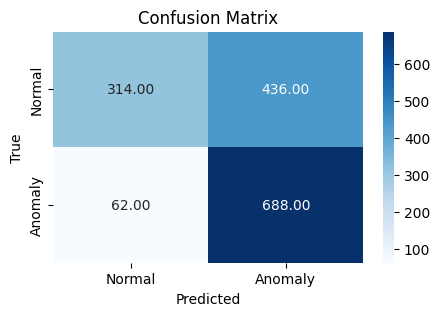

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrices = []
conf_matrix = confusion_matrix(y_test, anomalies)
conf_matrices.append(conf_matrix)

# Calculate average confusion matrix
avg_conf_matrix = np.mean(conf_matrices, axis=0)

# Plotting average confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(avg_conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

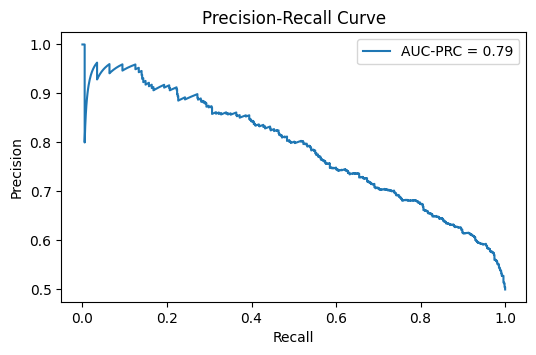

In [16]:
from sklearn.metrics import precision_recall_curve, auc
all_precisions = []
all_recalls = []
num_folds = len(all_train_loss)

plt.figure(figsize=(6, 3.5))
for i in range(num_folds):
    # Calculate precision-recall curve values for the current fold
    precision, recall, _ = precision_recall_curve(y_test, reconstruction_errors)

    # Append precision and recall values to the lists
    all_precisions.append(precision)
    all_recalls.append(recall)

# Calculate the mean precision and recall
mean_precision = np.mean(all_precisions, axis=0)
mean_recall = np.mean(all_recalls, axis=0)

# Calculate AUC-PRC for the mean curve
auc_prc_mean = auc(mean_recall, mean_precision)

# Plot
plt.plot(mean_recall, mean_precision, label=f'AUC-PRC = {auc_prc_mean:.2f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


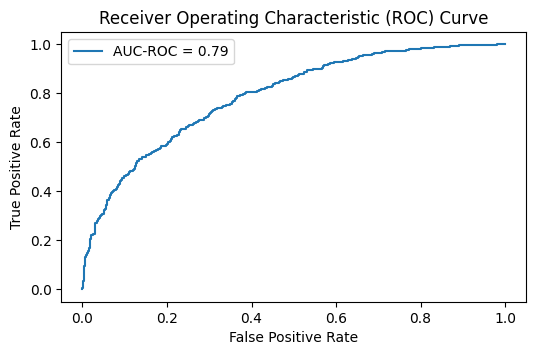

In [18]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_errors)

# Calculate AUC-ROC
auc_roc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 3.5))
plt.plot(fpr, tpr, label=f'AUC-ROC = {auc_roc:.2f}')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


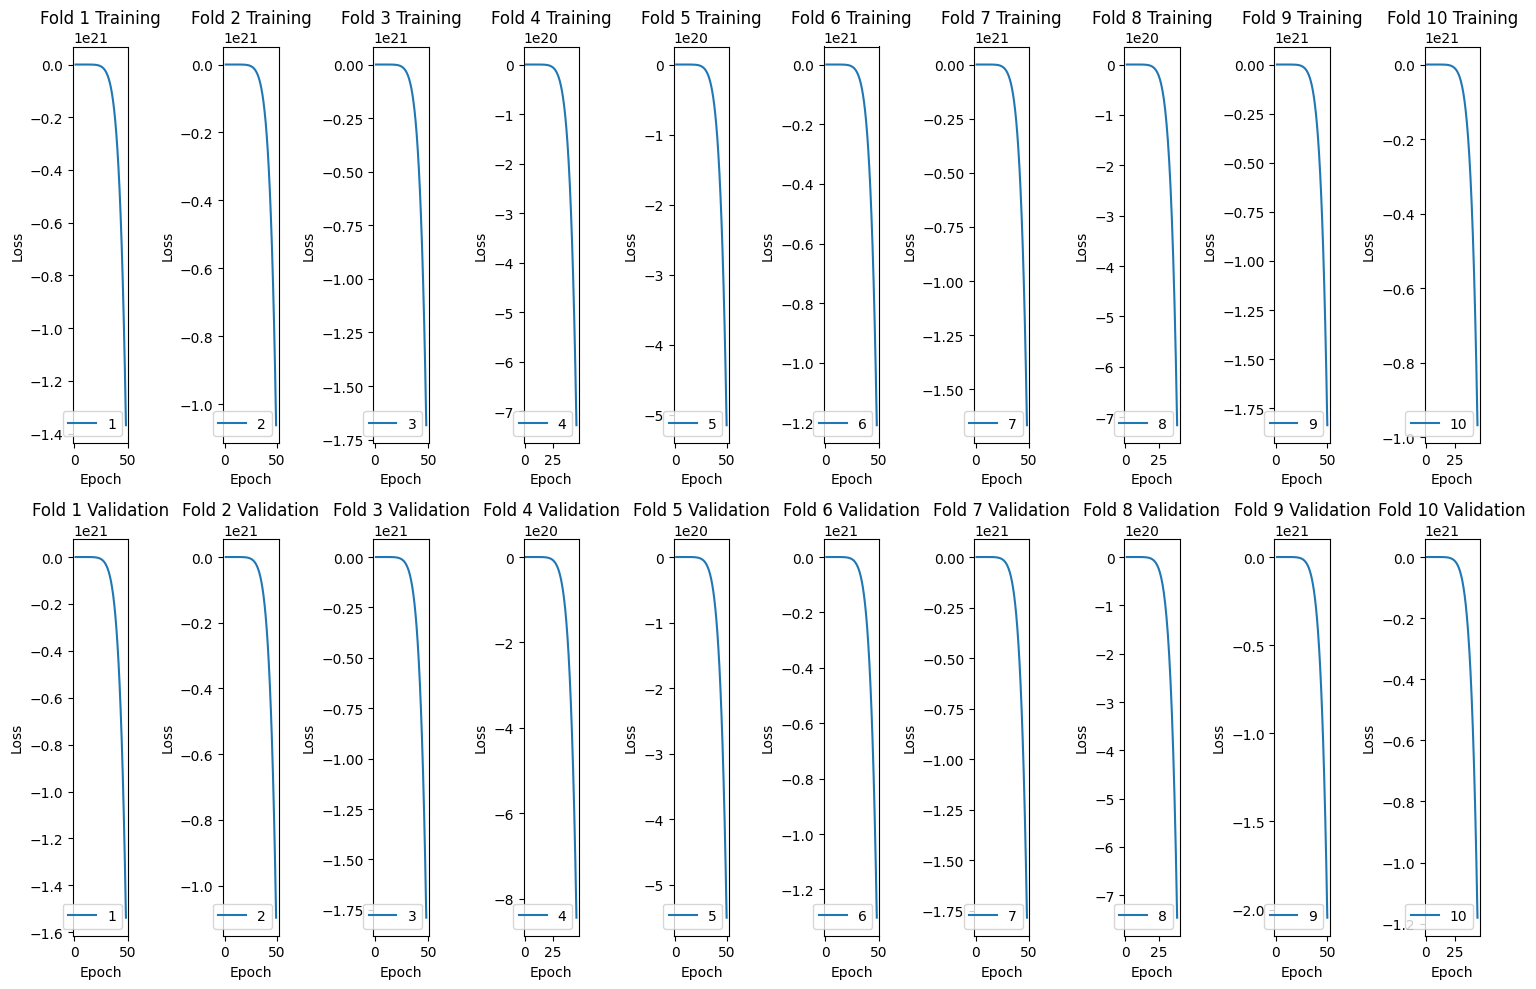

In [19]:
# Number of folds
num_folds = len(all_train_loss)

# Create a separate plot for each fold
plt.figure(figsize=(15, 10))

for i in range(num_folds):
    # Number of epochs for the current fold
    num_epochs_train = len(all_train_loss[i])
    num_epochs_val = len(all_val_loss[i])

   # Plotting training loss
    plt.subplot(2, num_folds, i+1)
    plt.plot(range(1, num_epochs_train + 1), all_train_loss[i], label=f'{i + 1}')
    plt.title(f'Fold {i + 1} Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting validation loss
    plt.subplot(2, num_folds, i+num_folds+1)
    plt.plot(range(1, num_epochs_val + 1), all_val_loss[i], label=f'{i + 1}')
    plt.title(f'Fold {i + 1} Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()


47/47 [==============================] - 0s 2ms/step


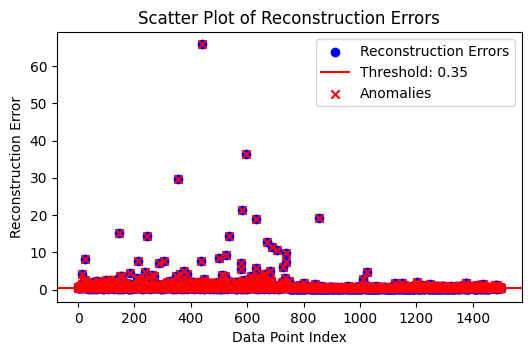

In [20]:
# Calculate reconstruction errors on the test set
reconstruction_errors = np.mean(np.square(X_test_scaled - autoencoder.predict(X_test_scaled)), axis=1)

# Plotting
plt.figure(figsize=(6, 3.5))
plt.scatter(range(len(reconstruction_errors)), reconstruction_errors, c='blue', label='Reconstruction Errors')
plt.axhline(y=threshold, color='r', linestyle='-', label=f'Threshold: {threshold:.2f}')
plt.scatter(np.where(anomalies)[0], reconstruction_errors[anomalies], c='red', marker='x', label='Anomalies')
plt.title(f'Scatter Plot of Reconstruction Errors')
plt.xlabel('Data Point Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()


In [ ]:
# Initialize dictionary to store importance scores for each feature
feature_importance_scores = {}

# Iterate over each feature for ablation
for feature_to_ablate in predictors.columns:
    feature_scores = []
    for train_index, test_index in skf.split(predictors, target):
        X_train, X_test = predictors.iloc[train_index], predictors.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

        # Drop the current feature for ablation
        X_train_ablated = X_train.drop(columns=[feature_to_ablate])
        X_val_ablated = X_val.drop(columns=[feature_to_ablate])
        X_test_ablated = X_test.drop(columns=[feature_to_ablate])

        # Standardize data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_ablated)
        X_val_scaled = scaler.transform(X_val_ablated)
        X_test_scaled = scaler.transform(X_test_ablated)

        # Train the autoencoder
        autoencoder_epochs = 50
        autoencoder_batch_size = 32

        input_dim = X_train_scaled.shape[1]
        latent_dim = 16

        # architecture
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(256, activation="relu")(input_layer)
        encoded = Dense(128, activation="relu")(encoded)
        encoded = Dense(64, activation="relu")(encoded)
        encoded = Dense(32, activation="relu")(encoded)
        encoded = Dense(16, activation="relu")(encoded)
        decoded = Dense(16, activation="relu")(encoded)
        decoded = Dense(32, activation="relu")(decoded)
        decoded = Dense(64, activation="relu")(decoded)
        decoded = Dense(128, activation="relu")(decoded)
        decoded = Dense(256, activation="relu")(decoded)
        decoded = Dense(input_dim, activation="sigmoid")(decoded)

        autoencoder = Model(input_layer, decoded)

        # Reduce the learning rate
        autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy")

        # Store training history
        history = autoencoder.fit(
            X_train_scaled, X_train_scaled,
            validation_data=(X_val_scaled, X_val_scaled),
            epochs=autoencoder_epochs,
            batch_size=autoencoder_batch_size,
            verbose=1,
            callbacks=[
                ModelCheckpoint(filepath="./autoencoder_best_model.h5", save_best_only=True, verbose=0),
                EarlyStopping(patience=3)
            ]
        )
        all_train_loss.append(history.history['loss'])
        all_val_loss.append(history.history['val_loss'])

        autoencoder.load_weights("./autoencoder_best_model.h5")

        # Calculate reconstruction errors
        reconstruction_errors = np.mean(np.square(X_test_scaled - autoencoder.predict(X_test_scaled)), axis=1)

        # Identify anomalies
        anomalies = reconstruction_errors > threshold

        # Evaluate performance
        f1_test = f1_score(y_test, anomalies)

        # Append F1 score to the list
        feature_scores.append(f1_test)

    # Calculate mean F1 score across folds for the current feature ablation
    mean_feature_f1 = np.mean(feature_scores)

    # Add mean F1 score to the dictionary
    feature_importance_scores[feature_to_ablate] = mean_feature_f1

# Print average importance scores for each feature in descending order
print("\nAverage Importance Scores Across Features (Descending Order):")
for feature, importance_score in sorted(feature_importance_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"Feature {feature}: {importance_score}")
